# Sample Workflow for d3rlpy Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import subprocess
import os
import d3rlpy
plt.style.use('matplotlibrc')

from Python.data_sampler import *

## Building an MDPDataset

We first read in a large batch of samples from the file. As `d3rlpy` wants it in the form (observations, actions, rewards, terminal flags), we go ahead and do that. Here's a helper function to get a dataset from a list of chunks of your choosing.

In [3]:
def get_dataset(chunks : list, batch_size=30000, 
                path="collected_data/rl_det_small.txt") -> d3rlpy.dataset.MDPDataset :
    random.seed(0)
    samples = DataSampler(path_to_data=path)
    states = []
    actions = []
    rewards = []
    next_states = []
    for chunk in chunks:
        samples.use_chunk(chunk)
        samples.read_chunk()
        [statesChunk, actionsChunk, rewardsChunk, nextStatesChunk] = samples.get_batch(batch_size)
        states.append(statesChunk)
        actions.append(actionsChunk)
        rewards.append(rewardsChunk)
        next_states.append(nextStatesChunk)
    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)
    next_states = torch.cat(next_states)
    terminals = np.zeros(len(states))
    terminals[::100] = 1 #episode length 100, change if necessary
    print(states.shape)
    dataset = d3rlpy.dataset.MDPDataset(states.numpy(), 
                                        actions.numpy(), 
                                        rewards.numpy(), terminals)
    return dataset, states.numpy(), actions.numpy(), rewards.numpy()

We can build the dataset from there, just like this, and split into train and test sets.

In [27]:
dataset, states, actions, rewards = get_dataset([2,3,4,5,6,7,8], path="collected_data/rl_det_small.txt")

[ 0.00000000e+00  7.95731469e+08 -1.03891077e-02 -1.41999953e-02
 -2.10001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.78778459e-03 -1.34615461e-02  4.84073546e-02]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -8.17891077e-02 -1.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.09713430e-01 -2.63658359e-01  6.00000000e-01]
Read chunk # 4 out of 10000
[ 0.00000000e+00  7.95731469e+08 -7.24891077e-02 -1.35999953e-02
 -4.20001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -6.23311010e-02 -1.64283998e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08  1.24610892e-01  2.40000469e-03
 -7.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.20016566e-01  3.79282423e-01 -6.00000000e-01]
Read chunk # 6 out of 10000
[ 0.00000000e+00  7.95731469e+08  7.01089229e-03 -4.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.21623335e-01 -2.86362315e-02 -8.00

In [28]:
print("The behavior policy value statistics are:")
dataset.compute_stats()['return']

The behavior policy value statistics are:


{'mean': -3.7356715,
 'std': 2.1977918,
 'min': -12.578862,
 'max': 0.0,
 'histogram': (array([ 26,   9,   7,   9,  11,  10,  22,  25,  23,  62,  79, 102, 175,
         154, 333, 348, 216, 192, 118,  23]),
  array([-12.578862 , -11.949919 , -11.320976 , -10.692033 , -10.063089 ,
          -9.434147 ,  -8.805203 ,  -8.17626  ,  -7.5473175,  -6.918374 ,
          -6.289431 ,  -5.660488 ,  -5.0315447,  -4.4026017,  -3.7736588,
          -3.1447155,  -2.5157723,  -1.8868294,  -1.2578862,  -0.6289431,
           0.       ], dtype=float32))}

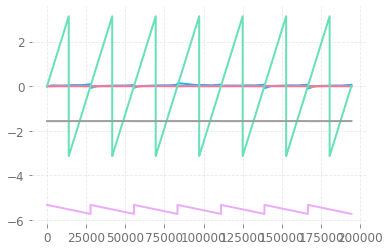

In [31]:
plt.plot(states)

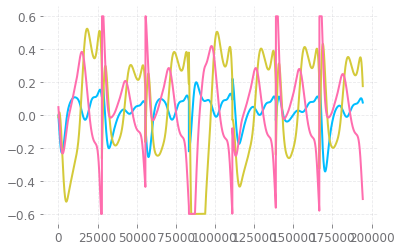

In [29]:
plt.plot(actions)

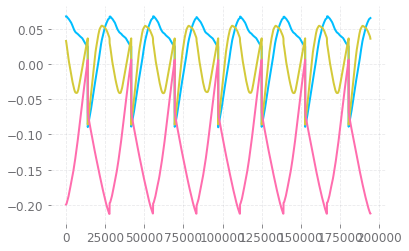

In [30]:
plt.plot(model.predict(states))

In [10]:
from sklearn.model_selection import train_test_split
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

## Setting up an Algorithm

In [11]:
from d3rlpy.dynamics import ProbabilisticEnsembleDynamics
from d3rlpy.metrics.scorer import dynamics_observation_prediction_error_scorer
from d3rlpy.metrics.scorer import dynamics_reward_prediction_error_scorer
from d3rlpy.metrics.scorer import dynamics_prediction_variance_scorer

dynamics = d3rlpy.dynamics.ProbabilisticEnsembleDynamics(learning_rate=1e-4, use_gpu=False)

# same as algorithms
dynamics.fit(train_episodes,
             eval_episodes=test_episodes,
             n_epochs=15, tensorboard_dir='runs',
             scorers={
                'observation_error': dynamics_observation_prediction_error_scorer,
                'reward_error': dynamics_reward_prediction_error_scorer,
                'variance': dynamics_prediction_variance_scorer,
             })


#from d3rlpy.algos import MOPO

# load trained dynamics model
#dynamics = ProbabilisticEnsembleDynamics.from_json('<path-to-params.json>/params.json')
#dynamics.load_model('<path-to-model>/model_xx.pt')

# give mopo as generator argument.
#mopo = MOPO(dynamics=dynamics)


2022-04-10 23:09.49 [debug    ] RoundIterator is selected.
2022-04-10 23:09.49 [info     ] Directory is created at d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949
2022-04-10 23:09.49 [debug    ] Building models...
2022-04-10 23:09.49 [debug    ] Models have been built.
2022-04-10 23:09.49 [info     ] Parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/params.json params={'action_scaler': None, 'batch_size': 100, 'discrete_action': False, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_ensembles': 5, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'use_gpu': None, 'variance_type': 'max', 'algorithm': 'ProbabilisticEnsembleDynamics', 'observation_shape': 

Epoch 1/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:09.57 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.00017305957429229805, 'time_algorithm_update': 0.007352048280841941, 'loss': -140.10510917097872, 'time_step': 0.007589232134113008, 'observation_error': 0.0018325344901594142, 'reward_error': 9.974191703448138e-05, 'variance': 3.081869973614214e-08} step=878
2022-04-10 23:09.57 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_878.pt


Epoch 2/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.05 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.00015363959353714162, 'time_algorithm_update': 0.0074154991223763225, 'loss': -151.63201441145705, 'time_step': 0.007624332888522833, 'observation_error': 0.001807959675438991, 'reward_error': 5.933092025833214e-05, 'variance': 9.828360865930913e-08} step=1756
2022-04-10 23:10.05 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_1756.pt


Epoch 3/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.13 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.0001461505889892578, 'time_algorithm_update': 0.007192408848460552, 'loss': -166.4510596064609, 'time_step': 0.00738348884843205, 'observation_error': 0.0018089718232420938, 'reward_error': 4.5506748029633746e-05, 'variance': 4.406671234392696e-07} step=2634
2022-04-10 23:10.13 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_2634.pt


Epoch 4/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.20 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.00014128636119034403, 'time_algorithm_update': 0.007013310060957298, 'loss': -164.94749833891223, 'time_step': 0.007198953954396867, 'observation_error': 0.0018049174530033406, 'reward_error': 2.881410699376538e-05, 'variance': 9.310019114011375e-08} step=3512
2022-04-10 23:10.20 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_3512.pt


Epoch 5/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.28 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.00014967663141480882, 'time_algorithm_update': 0.007224242888170386, 'loss': -165.57158719977377, 'time_step': 0.00742547169904774, 'observation_error': 0.001801802697047647, 'reward_error': 1.6113058562165167e-05, 'variance': 2.4929791207708274e-07} step=4390
2022-04-10 23:10.28 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_4390.pt


Epoch 6/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.35 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.00014423292155689422, 'time_algorithm_update': 0.006967779715674885, 'loss': -169.68840476972366, 'time_step': 0.007161178458524456, 'observation_error': 0.0018020735734158694, 'reward_error': 1.0416668903290916e-05, 'variance': 1.0633654922450228e-07} step=5268
2022-04-10 23:10.35 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_5268.pt


Epoch 7/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.42 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.00014556051658334927, 'time_algorithm_update': 0.007200861846124393, 'loss': -172.42057374506714, 'time_step': 0.007396729497540241, 'observation_error': 0.001799306955841956, 'reward_error': 5.341980336090955e-06, 'variance': 1.166636151673255e-07} step=6146
2022-04-10 23:10.43 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_6146.pt


Epoch 8/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.50 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.0001501336456159796, 'time_algorithm_update': 0.007431847087886176, 'loss': -174.64853993200768, 'time_step': 0.00763223545969483, 'observation_error': 0.0017980728337827574, 'reward_error': 5.559371331149771e-06, 'variance': 2.837863535494045e-07} step=7024
2022-04-10 23:10.50 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_7024.pt


Epoch 9/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:10.58 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.000141644260606353, 'time_algorithm_update': 0.007064545344654683, 'loss': -177.4460631264098, 'time_step': 0.007248989270325402, 'observation_error': 0.001802331460846831, 'reward_error': 7.97423366372391e-06, 'variance': 3.9587691236573405e-07} step=7902
2022-04-10 23:10.58 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_7902.pt


Epoch 10/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:11.04 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.00012945911607329557, 'time_algorithm_update': 0.006263070606153484, 'loss': -179.6604058563302, 'time_step': 0.006434879704868604, 'observation_error': 0.0017995717941641969, 'reward_error': 3.437062126706591e-06, 'variance': 2.731058813709189e-07} step=8780
2022-04-10 23:11.04 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_8780.pt


Epoch 11/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:11.10 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.00011612912788478009, 'time_algorithm_update': 0.005877527940789225, 'loss': -181.65793715196753, 'time_step': 0.006030654581369734, 'observation_error': 0.0017985903850482367, 'reward_error': 6.550298879763381e-06, 'variance': 7.933408183111245e-08} step=9658
2022-04-10 23:11.10 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_9658.pt


Epoch 12/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:11.16 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.00011469318546303856, 'time_algorithm_update': 0.0057431158009314046, 'loss': -183.1813553221405, 'time_step': 0.005892961877896737, 'observation_error': 0.0018049531087494484, 'reward_error': 5.420319465465973e-06, 'variance': 2.168562424631708e-07} step=10536
2022-04-10 23:11.16 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_10536.pt


Epoch 13/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:11.22 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.00011926875842187834, 'time_algorithm_update': 0.005741655147700212, 'loss': -184.6768489828957, 'time_step': 0.005899553689978389, 'observation_error': 0.0018005062788018268, 'reward_error': 2.236410144069664e-06, 'variance': 4.9132510349474726e-08} step=11414
2022-04-10 23:11.22 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_11414.pt


Epoch 14/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:11.29 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.0001182273743092878, 'time_algorithm_update': 0.00583908362377749, 'loss': -186.44792735549476, 'time_step': 0.005996132222829484, 'observation_error': 0.0017948265919102795, 'reward_error': 2.099422275587567e-06, 'variance': 5.1133812744547367e-08} step=12292
2022-04-10 23:11.29 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_12292.pt


Epoch 15/15:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-10 23:11.35 [info     ] ProbabilisticEnsembleDynamics_20220410230949: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.00012143000383311904, 'time_algorithm_update': 0.006084626247779655, 'loss': -186.90448276111368, 'time_step': 0.006242444412040276, 'observation_error': 0.001796619499993738, 'reward_error': 3.4065057776327213e-06, 'variance': 1.0149450957895942e-07} step=13170
2022-04-10 23:11.35 [info     ] Model parameters are saved to d3rlpy_logs/ProbabilisticEnsembleDynamics_20220410230949/model_13170.pt


[(1,
  {'time_sample_batch': 0.00017305957429229805,
   'time_algorithm_update': 0.007352048280841941,
   'loss': -140.10510917097872,
   'time_step': 0.007589232134113008,
   'observation_error': 0.0018325344901594142,
   'reward_error': 9.974191703448138e-05,
   'variance': 3.081869973614214e-08}),
 (2,
  {'time_sample_batch': 0.00015363959353714162,
   'time_algorithm_update': 0.0074154991223763225,
   'loss': -151.63201441145705,
   'time_step': 0.007624332888522833,
   'observation_error': 0.001807959675438991,
   'reward_error': 5.933092025833214e-05,
   'variance': 9.828360865930913e-08}),
 (3,
  {'time_sample_batch': 0.0001461505889892578,
   'time_algorithm_update': 0.007192408848460552,
   'loss': -166.4510596064609,
   'time_step': 0.00738348884843205,
   'observation_error': 0.0018089718232420938,
   'reward_error': 4.5506748029633746e-05,
   'variance': 4.406671234392696e-07}),
 (4,
  {'time_sample_batch': 0.00014128636119034403,
   'time_algorithm_update': 0.0070133100609

In [7]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 83036), started 0:02:45 ago. (Use '!kill 83036' to kill it.)

In [12]:
from d3rlpy.algos import COMBO
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer

# calculate metrics with test dataset
#ave_error_init = average_value_estimation_scorer(model, test_episodes)
#print(ave_error_init)

from d3rlpy.preprocessing import MinMaxActionScaler
action_scaler = MinMaxActionScaler(minimum=-0.6, maximum=0.6)

model = COMBO(q_func_factory='mean', #qr -> quantile regression q function, but you don't have to use this
            reward_scaler='standard',
              action_scaler = action_scaler,
        dynamics=dynamics,
          actor_learning_rate=3e-5, 
          critic_learning_rate=0.0003, 
            use_gpu=False) #change it to true if you have one
model.build_with_dataset(dataset)

model.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=5, 
        tensorboard_dir='runs',
        scorers={
            'td_error': td_error_scorer,
            'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer
        })

2022-04-10 23:11.35 [debug    ] RoundIterator is selected.
2022-04-10 23:11.35 [info     ] Directory is created at d3rlpy_logs/COMBO_20220410231135
2022-04-10 23:11.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-04-10 23:11.35 [debug    ] Fitting reward scaler...       reward_scaler=standard
2022-04-10 23:11.35 [warning  ] Skip building models since they're already built.
2022-04-10 23:11.35 [info     ] Parameters are saved to d3rlpy_logs/COMBO_20220410231135/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array(-0.6), 'maximum': array(0.6)}}, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 3e-05, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'conservative_weight': 1.0, 'critic_encoder_factory': {'type': 'default', 'params': {'activation'

Epoch 1/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-10 23:11.37 [debug    ] 250000 transitions are generated. fake_transitions=250000 real_transitions=87813
2022-04-10 23:11.44 [info     ] COMBO_20220410231135: epoch=1 step=343 epoch=1 metrics={'time_sample_batch': 0.00028219375943998553, 'time_algorithm_update': 0.01951007523272545, 'critic_loss': 9.38556343751468, 'actor_loss': -0.5965879530884847, 'temp_loss': 4.490356174919418, 'temp': 0.9834736166820581, 'time_step': 0.019854488595234063, 'td_error': 0.7799010412819757, 'init_value': 0.9010161757469177, 'ave_value': 0.9006855725744618} step=343
2022-04-10 23:11.44 [info     ] Model parameters are saved to d3rlpy_logs/COMBO_20220410231135/model_343.pt


Epoch 2/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-10 23:11.51 [info     ] COMBO_20220410231135: epoch=2 step=686 epoch=2 metrics={'time_sample_batch': 0.0004449224333026319, 'time_algorithm_update': 0.019318577151951916, 'critic_loss': 11.182261252889829, 'actor_loss': -2.2429668649640098, 'temp_loss': 4.499980961268567, 'temp': 0.9521451357849833, 'time_step': 0.019825153378633994, 'td_error': 0.5226452173270179, 'init_value': 2.409006357192993, 'ave_value': 2.410727785914494} step=686
2022-04-10 23:11.51 [info     ] Model parameters are saved to d3rlpy_logs/COMBO_20220410231135/model_686.pt


Epoch 3/5:   0%|          | 0/686 [00:00<?, ?it/s]

2022-04-10 23:11.59 [debug    ] 250000 transitions are generated. fake_transitions=500000 real_transitions=87813
2022-04-10 23:12.07 [info     ] COMBO_20220410231135: epoch=3 step=1372 epoch=3 metrics={'time_sample_batch': 0.0004489286300392262, 'time_algorithm_update': 0.019336686537495158, 'critic_loss': 10.267189637565057, 'actor_loss': -3.508037438198012, 'temp_loss': 4.352791214823375, 'temp': 0.9047392625850421, 'time_step': 0.01985275154558632, 'td_error': 0.8082031634693927, 'init_value': 4.145042419433594, 'ave_value': 4.144328079886021} step=1372
2022-04-10 23:12.07 [info     ] Model parameters are saved to d3rlpy_logs/COMBO_20220410231135/model_1372.pt


Epoch 4/5:   0%|          | 0/686 [00:00<?, ?it/s]

2022-04-10 23:12.21 [debug    ] 250000 transitions are generated. fake_transitions=750000 real_transitions=87813
2022-04-10 23:12.22 [info     ] COMBO_20220410231135: epoch=4 step=2058 epoch=4 metrics={'time_sample_batch': 0.00044087105520265095, 'time_algorithm_update': 0.0189809778341399, 'critic_loss': 10.060624470168579, 'actor_loss': -4.653405980188019, 'temp_loss': 4.085305779042814, 'temp': 0.8470284880597807, 'time_step': 0.019489746747142024, 'td_error': 1.5908133469987933, 'init_value': 5.167080879211426, 'ave_value': 5.161431179134322} step=2058
2022-04-10 23:12.22 [info     ] Model parameters are saved to d3rlpy_logs/COMBO_20220410231135/model_2058.pt


Epoch 5/5:   0%|          | 0/686 [00:00<?, ?it/s]

2022-04-10 23:12.36 [info     ] COMBO_20220410231135: epoch=5 step=2744 epoch=5 metrics={'time_sample_batch': 0.0004518052926911557, 'time_algorithm_update': 0.019267527077010353, 'critic_loss': 10.302340119295149, 'actor_loss': -4.972860995256519, 'temp_loss': 3.8237513880687968, 'temp': 0.7940831919453234, 'time_step': 0.01978130278017361, 'td_error': 2.373269231792134, 'init_value': 5.795220851898193, 'ave_value': 5.784876368612857} step=2744
2022-04-10 23:12.36 [info     ] Model parameters are saved to d3rlpy_logs/COMBO_20220410231135/model_2744.pt


[(1,
  {'time_sample_batch': 0.00028219375943998553,
   'time_algorithm_update': 0.01951007523272545,
   'critic_loss': 9.38556343751468,
   'actor_loss': -0.5965879530884847,
   'temp_loss': 4.490356174919418,
   'temp': 0.9834736166820581,
   'time_step': 0.019854488595234063,
   'td_error': 0.7799010412819757,
   'init_value': 0.9010161757469177,
   'ave_value': 0.9006855725744618}),
 (2,
  {'time_sample_batch': 0.0004449224333026319,
   'time_algorithm_update': 0.019318577151951916,
   'critic_loss': 11.182261252889829,
   'actor_loss': -2.2429668649640098,
   'temp_loss': 4.499980961268567,
   'temp': 0.9521451357849833,
   'time_step': 0.019825153378633994,
   'td_error': 0.5226452173270179,
   'init_value': 2.409006357192993,
   'ave_value': 2.410727785914494}),
 (3,
  {'time_sample_batch': 0.0004489286300392262,
   'time_algorithm_update': 0.019336686537495158,
   'critic_loss': 10.267189637565057,
   'actor_loss': -3.508037438198012,
   'temp_loss': 4.352791214823375,
   'temp

## Off-Policy Evaluation

We do get some metrics on a test set of initial state value and average value. However, these estimates (using the critic's Q-function) of model performance are biased. They're useful for validation during training, but not much else. Instead, we fit a Q-function to the data (or a separate dataset, as I've done here) separately and evaluate the model's performance on it.

Feel free to change the chunks and number of steps.

In [12]:
model.save_policy('comboDet.pt')

/Users/hetankevin/miniforge3/lib/python3.9/site-packages/d3rlpy/preprocessing/action_scalers.py:204: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  minimum = torch.tensor(
/Users/hetankevin/miniforge3/lib/python3.9/site-packages/d3rlpy/preprocessing/action_scalers.py:207: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  maximum = torch.tensor(


In [10]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer

ope_dataset = get_dataset([2,4,6,8], path="collected_data/rl_det_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes, eval_episodes=ope_test_episodes, 
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08 -1.03891077e-02 -1.41999953e-02
 -2.10001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.78778459e-03 -1.34615461e-02  4.84073546e-02]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -7.24891077e-02 -1.35999953e-02
 -4.20001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -6.23311010e-02 -1.64283998e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08  7.01089229e-03 -4.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.21623335e-01 -2.86362315e-02 -8.00043364e-02]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01 -1.37999953e-02
  7.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.76352555e-01 -3.26280816e-01  6.00000000e-01]
Read chunk # 9 out of 10000
torch.Size([111080, 6])
2022-04-07 19:48.50 [debug    ] RoundIterator is selected.
2022-04-07 19:48.50 [info     ] Directory is created at d3rlpy_logs/FQE_2022040719485

Epoch 1/50:   0%|          | 0/878 [00:00<?, ?it/s]

/Users/hetankevin/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hetankevin/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2022-04-07 19:48.53 [info     ] FQE_20220407194850: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.00014098385743508307, 'time_algorithm_update': 0.0019090096879928694, 'loss': 0.0006079547214486205, 'time_step': 0.0021188560542321692, 'init_value': -0.28840816020965576, 'ave_value': -0.28866724583605535, 'soft_opc': nan} step=878


2022-04-07 19:48.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_878.pt


Epoch 2/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:48.55 [info     ] FQE_20220407194850: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.00014134908862972043, 'time_algorithm_update': 0.0018845446288992985, 'loss': 0.0012250064993522321, 'time_step': 0.00208426798123162, 'init_value': -0.4084046483039856, 'ave_value': -0.4085957081498684, 'soft_opc': nan} step=1756


2022-04-07 19:48.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_1756.pt


Epoch 3/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:48.57 [info     ] FQE_20220407194850: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.00015009101268099217, 'time_algorithm_update': 0.0020265109446705883, 'loss': 0.0021275242328171145, 'time_step': 0.00224410102687827, 'init_value': -0.5219352841377258, 'ave_value': -0.5222797834360767, 'soft_opc': nan} step=2634


2022-04-07 19:48.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_2634.pt


Epoch 4/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:48.59 [info     ] FQE_20220407194850: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.0001335703430523362, 'time_algorithm_update': 0.0016752519477201213, 'loss': 0.0029731072644337106, 'time_step': 0.0018675987161101948, 'init_value': -0.548482358455658, 'ave_value': -0.5486275196931293, 'soft_opc': nan} step=3512


2022-04-07 19:48.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_3512.pt


Epoch 5/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.01 [info     ] FQE_20220407194850: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.0001448629114242241, 'time_algorithm_update': 0.0019243670487458179, 'loss': 0.00309454370744374, 'time_step': 0.0021335027755528756, 'init_value': -0.5471908450126648, 'ave_value': -0.5472799684939601, 'soft_opc': nan} step=4390


2022-04-07 19:49.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_4390.pt


Epoch 6/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.04 [info     ] FQE_20220407194850: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.0001419614279188708, 'time_algorithm_update': 0.0024540087628201635, 'loss': 0.0031645173893389824, 'time_step': 0.0026611385693039603, 'init_value': -0.5669634938240051, 'ave_value': -0.5669807058591938, 'soft_opc': nan} step=5268


2022-04-07 19:49.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_5268.pt


Epoch 7/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.06 [info     ] FQE_20220407194850: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.00014837646267137114, 'time_algorithm_update': 0.0019182246475393516, 'loss': 0.00317289999721975, 'time_step': 0.002134253060899183, 'init_value': -0.5370213985443115, 'ave_value': -0.5371544056625132, 'soft_opc': nan} step=6146


2022-04-07 19:49.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_6146.pt


Epoch 8/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.08 [info     ] FQE_20220407194850: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.00014348969644185894, 'time_algorithm_update': 0.0018090058567855245, 'loss': 0.0032100877413122238, 'time_step': 0.0020155005140022157, 'init_value': -0.5765939950942993, 'ave_value': -0.5767519605768846, 'soft_opc': nan} step=7024


2022-04-07 19:49.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_7024.pt


Epoch 9/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.10 [info     ] FQE_20220407194850: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.0001387047604710746, 'time_algorithm_update': 0.0017611437343519206, 'loss': 0.003562965304770195, 'time_step': 0.001964152538151839, 'init_value': -0.588071882724762, 'ave_value': -0.5881606059232182, 'soft_opc': nan} step=7902


2022-04-07 19:49.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_7902.pt


Epoch 10/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.12 [info     ] FQE_20220407194850: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.000142490130622186, 'time_algorithm_update': 0.0018443806024781664, 'loss': 0.0038599560598522285, 'time_step': 0.002051507693488397, 'init_value': -0.6292597055435181, 'ave_value': -0.6293768399491357, 'soft_opc': nan} step=8780


2022-04-07 19:49.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_8780.pt


Epoch 11/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.14 [info     ] FQE_20220407194850: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.00013953841085586027, 'time_algorithm_update': 0.0018321957294924656, 'loss': 0.004020931352498795, 'time_step': 0.002034785535721138, 'init_value': -0.6142115592956543, 'ave_value': -0.6144027234692394, 'soft_opc': nan} step=9658


2022-04-07 19:49.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_9658.pt


Epoch 12/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.16 [info     ] FQE_20220407194850: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.00012201600302867846, 'time_algorithm_update': 0.0015235712968135477, 'loss': 0.003971233364457088, 'time_step': 0.0017041187894643033, 'init_value': -0.6109127998352051, 'ave_value': -0.6111909745611801, 'soft_opc': nan} step=10536


2022-04-07 19:49.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_10536.pt


Epoch 13/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.18 [info     ] FQE_20220407194850: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.00012806607813389806, 'time_algorithm_update': 0.0015540682373394457, 'loss': 0.004124440234611219, 'time_step': 0.0017436642310070828, 'init_value': -0.6723973751068115, 'ave_value': -0.6727262635148294, 'soft_opc': nan} step=11414


2022-04-07 19:49.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_11414.pt


Epoch 14/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.20 [info     ] FQE_20220407194850: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.0001253668974092175, 'time_algorithm_update': 0.0015491888028885618, 'loss': 0.004894195457321413, 'time_step': 0.0017338727764225224, 'init_value': -0.6508049964904785, 'ave_value': -0.6511300045975137, 'soft_opc': nan} step=12292


2022-04-07 19:49.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_12292.pt


Epoch 15/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.21 [info     ] FQE_20220407194850: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.00012968993132641212, 'time_algorithm_update': 0.001607042510308546, 'loss': 0.004153197342788156, 'time_step': 0.001797948991519172, 'init_value': -0.6222880482673645, 'ave_value': -0.6226206263478761, 'soft_opc': nan} step=13170


2022-04-07 19:49.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_13170.pt


Epoch 16/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.23 [info     ] FQE_20220407194850: epoch=16 step=14048 epoch=16 metrics={'time_sample_batch': 0.00013001796053319423, 'time_algorithm_update': 0.0016185762127331014, 'loss': 0.003910564572055144, 'time_step': 0.0018098020336350983, 'init_value': -0.6139489412307739, 'ave_value': -0.6141650852150214, 'soft_opc': nan} step=14048


2022-04-07 19:49.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_14048.pt


Epoch 17/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.25 [info     ] FQE_20220407194850: epoch=17 step=14926 epoch=17 metrics={'time_sample_batch': 0.00012625730119153415, 'time_algorithm_update': 0.0015763524996121, 'loss': 0.0038726337262825366, 'time_step': 0.001765379601567644, 'init_value': -0.5876414179801941, 'ave_value': -0.5878606042406419, 'soft_opc': nan} step=14926


2022-04-07 19:49.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_14926.pt


Epoch 18/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.27 [info     ] FQE_20220407194850: epoch=18 step=15804 epoch=18 metrics={'time_sample_batch': 0.00012379273738296264, 'time_algorithm_update': 0.0015785254215596749, 'loss': 0.003659903031282962, 'time_step': 0.0017593588535769382, 'init_value': -0.6034366488456726, 'ave_value': -0.6036064844527376, 'soft_opc': nan} step=15804


2022-04-07 19:49.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_15804.pt


Epoch 19/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.29 [info     ] FQE_20220407194850: epoch=19 step=16682 epoch=19 metrics={'time_sample_batch': 0.00012326430622700406, 'time_algorithm_update': 0.0015189175182160049, 'loss': 0.0037361552177988286, 'time_step': 0.001702160118381092, 'init_value': -0.6020742058753967, 'ave_value': -0.6022639164119201, 'soft_opc': nan} step=16682


2022-04-07 19:49.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_16682.pt


Epoch 20/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.30 [info     ] FQE_20220407194850: epoch=20 step=17560 epoch=20 metrics={'time_sample_batch': 0.00012508991910547765, 'time_algorithm_update': 0.0015198410507758278, 'loss': 0.004283547543769841, 'time_step': 0.00170327373409054, 'init_value': -0.6489408612251282, 'ave_value': -0.649124080678953, 'soft_opc': nan} step=17560


2022-04-07 19:49.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_17560.pt


Epoch 21/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.32 [info     ] FQE_20220407194850: epoch=21 step=18438 epoch=21 metrics={'time_sample_batch': 0.00012541088808098796, 'time_algorithm_update': 0.0015685838012869102, 'loss': 0.004278583643735952, 'time_step': 0.0017535067364946857, 'init_value': -0.6528856754302979, 'ave_value': -0.6530297988849463, 'soft_opc': nan} step=18438


2022-04-07 19:49.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_18438.pt


Epoch 22/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.34 [info     ] FQE_20220407194850: epoch=22 step=19316 epoch=22 metrics={'time_sample_batch': 0.0001252180894577965, 'time_algorithm_update': 0.001573262562241261, 'loss': 0.004312108672440449, 'time_step': 0.001757071881739588, 'init_value': -0.6294997930526733, 'ave_value': -0.6296672753656603, 'soft_opc': nan} step=19316


2022-04-07 19:49.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_19316.pt


Epoch 23/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.36 [info     ] FQE_20220407194850: epoch=23 step=20194 epoch=23 metrics={'time_sample_batch': 0.00012083531512214817, 'time_algorithm_update': 0.0014838938832554566, 'loss': 0.004107380620518975, 'time_step': 0.0016599923440155516, 'init_value': -0.6225336194038391, 'ave_value': -0.6226709418232665, 'soft_opc': nan} step=20194


2022-04-07 19:49.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_20194.pt


Epoch 24/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.37 [info     ] FQE_20220407194850: epoch=24 step=21072 epoch=24 metrics={'time_sample_batch': 0.00012106450109112507, 'time_algorithm_update': 0.0015149632456090837, 'loss': 0.0040964599329420944, 'time_step': 0.0016927409552224405, 'init_value': -0.6306828260421753, 'ave_value': -0.6306369911678331, 'soft_opc': nan} step=21072


2022-04-07 19:49.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_21072.pt


Epoch 25/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.39 [info     ] FQE_20220407194850: epoch=25 step=21950 epoch=25 metrics={'time_sample_batch': 0.00012252624051174434, 'time_algorithm_update': 0.0015546773180603166, 'loss': 0.0040556680729961665, 'time_step': 0.0017347577492577068, 'init_value': -0.6314060688018799, 'ave_value': -0.6313676404789392, 'soft_opc': nan} step=21950


2022-04-07 19:49.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_21950.pt


Epoch 26/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.41 [info     ] FQE_20220407194850: epoch=26 step=22828 epoch=26 metrics={'time_sample_batch': 0.00011828847246452454, 'time_algorithm_update': 0.0014715564006553424, 'loss': 0.004258332785616352, 'time_step': 0.001645823546042475, 'init_value': -0.6578958034515381, 'ave_value': -0.6578331921294682, 'soft_opc': nan} step=22828


2022-04-07 19:49.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_22828.pt


Epoch 27/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.42 [info     ] FQE_20220407194850: epoch=27 step=23706 epoch=27 metrics={'time_sample_batch': 0.00012147833926259521, 'time_algorithm_update': 0.0014800126568874628, 'loss': 0.004506604511940947, 'time_step': 0.0016577987844688747, 'init_value': -0.6777089238166809, 'ave_value': -0.6775950481047442, 'soft_opc': nan} step=23706


2022-04-07 19:49.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_23706.pt


Epoch 28/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.44 [info     ] FQE_20220407194850: epoch=28 step=24584 epoch=28 metrics={'time_sample_batch': 0.00012354725857258929, 'time_algorithm_update': 0.0015428823870787046, 'loss': 0.00463228549544328, 'time_step': 0.0017255835218147157, 'init_value': -0.6665012240409851, 'ave_value': -0.6664280457822137, 'soft_opc': nan} step=24584


2022-04-07 19:49.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_24584.pt


Epoch 29/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.46 [info     ] FQE_20220407194850: epoch=29 step=25462 epoch=29 metrics={'time_sample_batch': 0.00012001659984197595, 'time_algorithm_update': 0.0014527685821463688, 'loss': 0.004254249760081989, 'time_step': 0.0016284768293550183, 'init_value': -0.6546343564987183, 'ave_value': -0.6544837074788545, 'soft_opc': nan} step=25462


2022-04-07 19:49.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_25462.pt


Epoch 30/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.48 [info     ] FQE_20220407194850: epoch=30 step=26340 epoch=30 metrics={'time_sample_batch': 0.0001184000784280903, 'time_algorithm_update': 0.0014364586332664402, 'loss': 0.004000720313246418, 'time_step': 0.0016101989767817538, 'init_value': -0.619335412979126, 'ave_value': -0.619207343428216, 'soft_opc': nan} step=26340


2022-04-07 19:49.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_26340.pt


Epoch 31/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.49 [info     ] FQE_20220407194850: epoch=31 step=27218 epoch=31 metrics={'time_sample_batch': 0.00012036092189015451, 'time_algorithm_update': 0.00156201507073057, 'loss': 0.0038665523626740315, 'time_step': 0.0017401479642863698, 'init_value': -0.6279152035713196, 'ave_value': -0.6278322641697894, 'soft_opc': nan} step=27218


2022-04-07 19:49.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_27218.pt


Epoch 32/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.51 [info     ] FQE_20220407194850: epoch=32 step=28096 epoch=32 metrics={'time_sample_batch': 0.00012134609569992726, 'time_algorithm_update': 0.0015219439135053978, 'loss': 0.004055329641353095, 'time_step': 0.0016991820585211751, 'init_value': -0.6325485706329346, 'ave_value': -0.6324408509425453, 'soft_opc': nan} step=28096


2022-04-07 19:49.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_28096.pt


Epoch 33/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.53 [info     ] FQE_20220407194850: epoch=33 step=28974 epoch=33 metrics={'time_sample_batch': 0.00013328467523318488, 'time_algorithm_update': 0.0016553597461118241, 'loss': 0.0037707445889549355, 'time_step': 0.0018514546826651536, 'init_value': -0.602290689945221, 'ave_value': -0.6022351570749712, 'soft_opc': nan} step=28974


2022-04-07 19:49.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_28974.pt


Epoch 34/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.55 [info     ] FQE_20220407194850: epoch=34 step=29852 epoch=34 metrics={'time_sample_batch': 0.0001363985087714054, 'time_algorithm_update': 0.001692198675151295, 'loss': 0.003646039285240373, 'time_step': 0.0018922804699943387, 'init_value': -0.5765743255615234, 'ave_value': -0.576544153638771, 'soft_opc': nan} step=29852


2022-04-07 19:49.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_29852.pt


Epoch 35/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.57 [info     ] FQE_20220407194850: epoch=35 step=30730 epoch=35 metrics={'time_sample_batch': 0.00012624372382370378, 'time_algorithm_update': 0.001559402785160004, 'loss': 0.003362278754119288, 'time_step': 0.0017429834617840674, 'init_value': -0.5659874677658081, 'ave_value': -0.5659668807151412, 'soft_opc': nan} step=30730


2022-04-07 19:49.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_30730.pt


Epoch 36/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:49.58 [info     ] FQE_20220407194850: epoch=36 step=31608 epoch=36 metrics={'time_sample_batch': 0.00012590130260702146, 'time_algorithm_update': 0.001543771433124238, 'loss': 0.003209509785349854, 'time_step': 0.0017263403242975812, 'init_value': -0.551683247089386, 'ave_value': -0.5516221187774235, 'soft_opc': nan} step=31608


2022-04-07 19:49.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_31608.pt


Epoch 37/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.00 [info     ] FQE_20220407194850: epoch=37 step=32486 epoch=37 metrics={'time_sample_batch': 0.00013499569512717002, 'time_algorithm_update': 0.0016873434084151491, 'loss': 0.003038007800560889, 'time_step': 0.0018846228345380015, 'init_value': -0.5527405738830566, 'ave_value': -0.5526889109180074, 'soft_opc': nan} step=32486


2022-04-07 19:50.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_32486.pt


Epoch 38/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.02 [info     ] FQE_20220407194850: epoch=38 step=33364 epoch=38 metrics={'time_sample_batch': 0.00012998727568189756, 'time_algorithm_update': 0.0015967997440173034, 'loss': 0.003355651836425487, 'time_step': 0.0017837269702642002, 'init_value': -0.577538788318634, 'ave_value': -0.5775358253425028, 'soft_opc': nan} step=33364


2022-04-07 19:50.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_33364.pt


Epoch 39/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.04 [info     ] FQE_20220407194850: epoch=39 step=34242 epoch=39 metrics={'time_sample_batch': 0.00012444472258617774, 'time_algorithm_update': 0.0015018765638520886, 'loss': 0.0033682351215756894, 'time_step': 0.00168385565416688, 'init_value': -0.5750241875648499, 'ave_value': -0.5750399614952286, 'soft_opc': nan} step=34242


2022-04-07 19:50.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_34242.pt


Epoch 40/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.06 [info     ] FQE_20220407194850: epoch=40 step=35120 epoch=40 metrics={'time_sample_batch': 0.00012029819445077813, 'time_algorithm_update': 0.001505951946580057, 'loss': 0.0037426345707707444, 'time_step': 0.0016834480615846117, 'init_value': -0.6245876550674438, 'ave_value': -0.6245940136292298, 'soft_opc': nan} step=35120


2022-04-07 19:50.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_35120.pt


Epoch 41/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.07 [info     ] FQE_20220407194850: epoch=41 step=35998 epoch=41 metrics={'time_sample_batch': 0.0001166553866618858, 'time_algorithm_update': 0.0014274728596889348, 'loss': 0.003907780774433644, 'time_step': 0.0016004805684361207, 'init_value': -0.6436333656311035, 'ave_value': -0.6436632287879188, 'soft_opc': nan} step=35998


2022-04-07 19:50.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_35998.pt


Epoch 42/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.09 [info     ] FQE_20220407194850: epoch=42 step=36876 epoch=42 metrics={'time_sample_batch': 0.0001084858844383431, 'time_algorithm_update': 0.001344405708660569, 'loss': 0.004249520876952573, 'time_step': 0.00150424907310677, 'init_value': -0.6569187641143799, 'ave_value': -0.6568611532054194, 'soft_opc': nan} step=36876


2022-04-07 19:50.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_36876.pt


Epoch 43/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.10 [info     ] FQE_20220407194850: epoch=43 step=37754 epoch=43 metrics={'time_sample_batch': 0.00010629096715488304, 'time_algorithm_update': 0.0013042093681040006, 'loss': 0.004346407966295374, 'time_step': 0.0014596525791837306, 'init_value': -0.6540560126304626, 'ave_value': -0.6540236075597704, 'soft_opc': nan} step=37754


2022-04-07 19:50.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_37754.pt


Epoch 44/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.12 [info     ] FQE_20220407194850: epoch=44 step=38632 epoch=44 metrics={'time_sample_batch': 0.0001113873679436964, 'time_algorithm_update': 0.0014548920824750409, 'loss': 0.004098066134169656, 'time_step': 0.0016190166625455191, 'init_value': -0.6373031139373779, 'ave_value': -0.637113315539553, 'soft_opc': nan} step=38632


2022-04-07 19:50.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_38632.pt


Epoch 45/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.14 [info     ] FQE_20220407194850: epoch=45 step=39510 epoch=45 metrics={'time_sample_batch': 0.00010688239729757461, 'time_algorithm_update': 0.001320150284126299, 'loss': 0.0042346671427661445, 'time_step': 0.0014786861480504342, 'init_value': -0.6459008455276489, 'ave_value': -0.6457697417433994, 'soft_opc': nan} step=39510


2022-04-07 19:50.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_39510.pt


Epoch 46/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.15 [info     ] FQE_20220407194850: epoch=46 step=40388 epoch=46 metrics={'time_sample_batch': 0.00011758462171619737, 'time_algorithm_update': 0.001429669134709178, 'loss': 0.004213964098832843, 'time_step': 0.0016036544139401516, 'init_value': -0.6639831066131592, 'ave_value': -0.6638660881918572, 'soft_opc': nan} step=40388


2022-04-07 19:50.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_40388.pt


Epoch 47/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.17 [info     ] FQE_20220407194850: epoch=47 step=41266 epoch=47 metrics={'time_sample_batch': 0.00011360237973154542, 'time_algorithm_update': 0.001401081986742302, 'loss': 0.004637526880728904, 'time_step': 0.0015685802711712744, 'init_value': -0.685788094997406, 'ave_value': -0.6857486167625548, 'soft_opc': nan} step=41266


2022-04-07 19:50.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_41266.pt


Epoch 48/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.18 [info     ] FQE_20220407194850: epoch=48 step=42144 epoch=48 metrics={'time_sample_batch': 0.0001090713405391893, 'time_algorithm_update': 0.0013541977063398426, 'loss': 0.004700668686967164, 'time_step': 0.0015149189833899566, 'init_value': -0.6674653887748718, 'ave_value': -0.6674280412528547, 'soft_opc': nan} step=42144


2022-04-07 19:50.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_42144.pt


Epoch 49/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.20 [info     ] FQE_20220407194850: epoch=49 step=43022 epoch=49 metrics={'time_sample_batch': 0.00010687886718193871, 'time_algorithm_update': 0.0013421830935467349, 'loss': 0.004718795993100761, 'time_step': 0.0015018081339182234, 'init_value': -0.6886864304542542, 'ave_value': -0.6886870941212089, 'soft_opc': nan} step=43022


2022-04-07 19:50.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_43022.pt


Epoch 50/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.22 [info     ] FQE_20220407194850: epoch=50 step=43900 epoch=50 metrics={'time_sample_batch': 0.0001044140318260106, 'time_algorithm_update': 0.0013078282797255114, 'loss': 0.0048197853892544655, 'time_step': 0.0014610472464072677, 'init_value': -0.7038307189941406, 'ave_value': -0.7038266831843507, 'soft_opc': nan} step=43900


2022-04-07 19:50.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407194850/model_43900.pt


[(1,
  {'time_sample_batch': 0.00014098385743508307,
   'time_algorithm_update': 0.0019090096879928694,
   'loss': 0.0006079547214486205,
   'time_step': 0.0021188560542321692,
   'init_value': -0.28840816020965576,
   'ave_value': -0.28866724583605535,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00014134908862972043,
   'time_algorithm_update': 0.0018845446288992985,
   'loss': 0.0012250064993522321,
   'time_step': 0.00208426798123162,
   'init_value': -0.4084046483039856,
   'ave_value': -0.4085957081498684,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00015009101268099217,
   'time_algorithm_update': 0.0020265109446705883,
   'loss': 0.0021275242328171145,
   'time_step': 0.00224410102687827,
   'init_value': -0.5219352841377258,
   'ave_value': -0.5222797834360767,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.0001335703430523362,
   'time_algorithm_update': 0.0016752519477201213,
   'loss': 0.0029731072644337106,
   'time_step': 0.0018675987161101948,
   '

In [11]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer

ope_dataset = get_dataset([2,4,6,8], path="collected_data/rl_stoch_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes, eval_episodes=ope_test_episodes, 
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08  1.39310892e-01  1.82000047e-02
 -1.00013420e-04  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -7.50230117e-02  3.69851546e-01 -6.00000000e-01]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.15389108e-01  1.64000047e-02
 -8.80001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -3.08831172e-01 -2.48178665e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.28589108e-01  1.20000047e-02
  1.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  7.75212759e-03 -3.52719043e-01  6.00000000e-01]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01  7.00000469e-03
 -8.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.65974295e-01 -2.19295880e-01  6.00000000e-01]
Read chunk # 9 out of 10000
torch.Size([111080, 6])
2022-04-07 19:50.22 [debug    ] RoundIterator is selected.
2022-04-07 19:50.22 [info     ] Directory is created at d3rlpy_logs/FQE_2022040719502

Epoch 1/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.24 [info     ] FQE_20220407195022: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.00010922530789038586, 'time_algorithm_update': 0.0013269965360810925, 'loss': 0.0009169417545932128, 'time_step': 0.0014889957149914021, 'init_value': -0.3336537480354309, 'ave_value': -0.3335277750286961, 'soft_opc': nan} step=878


2022-04-07 19:50.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_878.pt


Epoch 2/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.25 [info     ] FQE_20220407195022: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.00011259765451209691, 'time_algorithm_update': 0.0013444882590569777, 'loss': 0.001964072655541641, 'time_step': 0.0015072838863642178, 'init_value': -0.48161980509757996, 'ave_value': -0.4819707575342267, 'soft_opc': nan} step=1756


2022-04-07 19:50.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_1756.pt


Epoch 3/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.27 [info     ] FQE_20220407195022: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.00012065609386678708, 'time_algorithm_update': 0.0014837013561796219, 'loss': 0.0035081159272886825, 'time_step': 0.0016611716741852989, 'init_value': -0.5360317230224609, 'ave_value': -0.5367158918235728, 'soft_opc': nan} step=2634


2022-04-07 19:50.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_2634.pt


Epoch 4/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.29 [info     ] FQE_20220407195022: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.00012901187757696268, 'time_algorithm_update': 0.0016377564171723732, 'loss': 0.004300679627766237, 'time_step': 0.001826680602679763, 'init_value': -0.5670409798622131, 'ave_value': -0.5679121116861251, 'soft_opc': nan} step=3512


2022-04-07 19:50.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_3512.pt


Epoch 5/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.31 [info     ] FQE_20220407195022: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.00012773451881148006, 'time_algorithm_update': 0.0015860779681890049, 'loss': 0.005298091582691399, 'time_step': 0.0017747439121602608, 'init_value': -0.5963019728660583, 'ave_value': -0.5974139589933607, 'soft_opc': nan} step=4390


2022-04-07 19:50.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_4390.pt


Epoch 6/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.33 [info     ] FQE_20220407195022: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.00012356979700318773, 'time_algorithm_update': 0.0016503983043592448, 'loss': 0.006298649211361644, 'time_step': 0.0018316841342726166, 'init_value': -0.6516246199607849, 'ave_value': -0.6529435249586389, 'soft_opc': nan} step=5268


2022-04-07 19:50.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_5268.pt


Epoch 7/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.34 [info     ] FQE_20220407195022: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.00011987267974297387, 'time_algorithm_update': 0.0014505723071261255, 'loss': 0.007762361717625963, 'time_step': 0.0016265643213224303, 'init_value': -0.7172123789787292, 'ave_value': -0.7186235047648359, 'soft_opc': nan} step=6146


2022-04-07 19:50.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_6146.pt


Epoch 8/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.36 [info     ] FQE_20220407195022: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.00011909605430307584, 'time_algorithm_update': 0.0014340443057188413, 'loss': 0.0077507040966891694, 'time_step': 0.0016092909224212576, 'init_value': -0.7303751707077026, 'ave_value': -0.7318628061988509, 'soft_opc': nan} step=7024


2022-04-07 19:50.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_7024.pt


Epoch 9/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.38 [info     ] FQE_20220407195022: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.0001209985150834694, 'time_algorithm_update': 0.001472486993446437, 'loss': 0.008759497603336025, 'time_step': 0.001652145983146372, 'init_value': -0.7524876594543457, 'ave_value': -0.7540609693182451, 'soft_opc': nan} step=7902


2022-04-07 19:50.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_7902.pt


Epoch 10/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.39 [info     ] FQE_20220407195022: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.000126442224941384, 'time_algorithm_update': 0.0015727175666965492, 'loss': 0.009895807106377292, 'time_step': 0.0017590357122225751, 'init_value': -0.865785539150238, 'ave_value': -0.8673962681926036, 'soft_opc': nan} step=8780


2022-04-07 19:50.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_8780.pt


Epoch 11/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.41 [info     ] FQE_20220407195022: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.0001253595656305891, 'time_algorithm_update': 0.0015838208665608818, 'loss': 0.010407614959530414, 'time_step': 0.0017612928138506982, 'init_value': -0.818297803401947, 'ave_value': -0.8199825416453095, 'soft_opc': nan} step=9658


2022-04-07 19:50.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_9658.pt


Epoch 12/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.43 [info     ] FQE_20220407195022: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.00011877019747514659, 'time_algorithm_update': 0.001431864051992638, 'loss': 0.009965066626779071, 'time_step': 0.001604144285371472, 'init_value': -0.7926100492477417, 'ave_value': -0.7941607457740495, 'soft_opc': nan} step=10536


2022-04-07 19:50.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_10536.pt


Epoch 13/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.44 [info     ] FQE_20220407195022: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.00011448300780902419, 'time_algorithm_update': 0.0013623794281944328, 'loss': 0.009536507324992685, 'time_step': 0.0015310793096763942, 'init_value': -0.7755937576293945, 'ave_value': -0.7771935509888597, 'soft_opc': nan} step=11414


2022-04-07 19:50.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_11414.pt


Epoch 14/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.46 [info     ] FQE_20220407195022: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.00012155274323830572, 'time_algorithm_update': 0.0014905351169560114, 'loss': 0.009383234377899556, 'time_step': 0.0016710421490506323, 'init_value': -0.8126031756401062, 'ave_value': -0.8140570376802883, 'soft_opc': nan} step=12292


2022-04-07 19:50.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_12292.pt


Epoch 15/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.48 [info     ] FQE_20220407195022: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.000119087636335021, 'time_algorithm_update': 0.0014282953766320996, 'loss': 0.009501458502193751, 'time_step': 0.0016045964117202237, 'init_value': -0.8052887916564941, 'ave_value': -0.8068868319672746, 'soft_opc': nan} step=13170


2022-04-07 19:50.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_13170.pt


Epoch 16/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.49 [info     ] FQE_20220407195022: epoch=16 step=14048 epoch=16 metrics={'time_sample_batch': 0.00011965707114182736, 'time_algorithm_update': 0.001444247426096019, 'loss': 0.010080996675859584, 'time_step': 0.0016198505844776615, 'init_value': -0.8580352663993835, 'ave_value': -0.8595553857140669, 'soft_opc': nan} step=14048


2022-04-07 19:50.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_14048.pt


Epoch 17/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.51 [info     ] FQE_20220407195022: epoch=17 step=14926 epoch=17 metrics={'time_sample_batch': 0.00012781462528167932, 'time_algorithm_update': 0.0016274406046422032, 'loss': 0.010262681080680035, 'time_step': 0.0018087245337240789, 'init_value': -0.8125917315483093, 'ave_value': -0.8141502371936079, 'soft_opc': nan} step=14926


2022-04-07 19:50.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_14926.pt


Epoch 18/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.53 [info     ] FQE_20220407195022: epoch=18 step=15804 epoch=18 metrics={'time_sample_batch': 0.00011865125973295242, 'time_algorithm_update': 0.0014589916329177475, 'loss': 0.00948240195789046, 'time_step': 0.0016340359468394912, 'init_value': -0.8252571225166321, 'ave_value': -0.826669245601104, 'soft_opc': nan} step=15804


2022-04-07 19:50.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_15804.pt


Epoch 19/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.55 [info     ] FQE_20220407195022: epoch=19 step=16682 epoch=19 metrics={'time_sample_batch': 0.00011357060869082231, 'time_algorithm_update': 0.0013451983553945067, 'loss': 0.009235900887870643, 'time_step': 0.0015146414619915034, 'init_value': -0.7787498235702515, 'ave_value': -0.7801543690705314, 'soft_opc': nan} step=16682


2022-04-07 19:50.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_16682.pt


Epoch 20/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.56 [info     ] FQE_20220407195022: epoch=20 step=17560 epoch=20 metrics={'time_sample_batch': 0.00012321705698695434, 'time_algorithm_update': 0.0015087879871724678, 'loss': 0.009129258467972225, 'time_step': 0.0016908531579993037, 'init_value': -0.8057368397712708, 'ave_value': -0.8071689134446878, 'soft_opc': nan} step=17560


2022-04-07 19:50.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_17560.pt


Epoch 21/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:50.58 [info     ] FQE_20220407195022: epoch=21 step=18438 epoch=21 metrics={'time_sample_batch': 0.00011809214372569716, 'time_algorithm_update': 0.0014280148682127237, 'loss': 0.009009543699998889, 'time_step': 0.0016033084626078335, 'init_value': -0.8090533018112183, 'ave_value': -0.8105253397045888, 'soft_opc': nan} step=18438


2022-04-07 19:50.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_18438.pt


Epoch 22/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.00 [info     ] FQE_20220407195022: epoch=22 step=19316 epoch=22 metrics={'time_sample_batch': 0.00011752841141337958, 'time_algorithm_update': 0.001480767015444119, 'loss': 0.008793721086114025, 'time_step': 0.001656214848737782, 'init_value': -0.7687418460845947, 'ave_value': -0.7702400462339377, 'soft_opc': nan} step=19316


2022-04-07 19:51.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_19316.pt


Epoch 23/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.01 [info     ] FQE_20220407195022: epoch=23 step=20194 epoch=23 metrics={'time_sample_batch': 0.00011942028184686543, 'time_algorithm_update': 0.0014979374978971373, 'loss': 0.00933834881907035, 'time_step': 0.0016749480862280773, 'init_value': -0.8161225318908691, 'ave_value': -0.8176952671385691, 'soft_opc': nan} step=20194


2022-04-07 19:51.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_20194.pt


Epoch 24/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.03 [info     ] FQE_20220407195022: epoch=24 step=21072 epoch=24 metrics={'time_sample_batch': 0.00012009073227032985, 'time_algorithm_update': 0.0014945336517820597, 'loss': 0.009985158265124416, 'time_step': 0.0016716476996558674, 'init_value': -0.8404918909072876, 'ave_value': -0.8419305856459481, 'soft_opc': nan} step=21072


2022-04-07 19:51.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_21072.pt


Epoch 25/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.05 [info     ] FQE_20220407195022: epoch=25 step=21950 epoch=25 metrics={'time_sample_batch': 0.00011272446712763272, 'time_algorithm_update': 0.0013690146878531418, 'loss': 0.009376503295791287, 'time_step': 0.0015378218305409635, 'init_value': -0.8283095955848694, 'ave_value': -0.829676948170526, 'soft_opc': nan} step=21950


2022-04-07 19:51.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_21950.pt


Epoch 26/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.06 [info     ] FQE_20220407195022: epoch=26 step=22828 epoch=26 metrics={'time_sample_batch': 0.0001121631787415246, 'time_algorithm_update': 0.0013528744560710932, 'loss': 0.00921558478539074, 'time_step': 0.0015183510704301212, 'init_value': -0.8004833459854126, 'ave_value': -0.8018802840956345, 'soft_opc': nan} step=22828


2022-04-07 19:51.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_22828.pt


Epoch 27/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.08 [info     ] FQE_20220407195022: epoch=27 step=23706 epoch=27 metrics={'time_sample_batch': 0.00011566668273647716, 'time_algorithm_update': 0.0014197142086159395, 'loss': 0.009182989306146553, 'time_step': 0.001591851608085198, 'init_value': -0.7923828959465027, 'ave_value': -0.7938472524600186, 'soft_opc': nan} step=23706


2022-04-07 19:51.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_23706.pt


Epoch 28/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.10 [info     ] FQE_20220407195022: epoch=28 step=24584 epoch=28 metrics={'time_sample_batch': 0.00011343429191780525, 'time_algorithm_update': 0.0014556290620008742, 'loss': 0.00909335764960291, 'time_step': 0.00162329516269623, 'init_value': -0.7930539846420288, 'ave_value': -0.7944853714165974, 'soft_opc': nan} step=24584


2022-04-07 19:51.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_24584.pt


Epoch 29/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.11 [info     ] FQE_20220407195022: epoch=29 step=25462 epoch=29 metrics={'time_sample_batch': 0.00012193209489548668, 'time_algorithm_update': 0.0014850506749946055, 'loss': 0.008984045130799045, 'time_step': 0.0016658927965272803, 'init_value': -0.8247576951980591, 'ave_value': -0.8261486931134526, 'soft_opc': nan} step=25462


2022-04-07 19:51.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_25462.pt


Epoch 30/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.13 [info     ] FQE_20220407195022: epoch=30 step=26340 epoch=30 metrics={'time_sample_batch': 0.00011413705647670598, 'time_algorithm_update': 0.001363787129691087, 'loss': 0.0092587838398727, 'time_step': 0.0015336769316897033, 'init_value': -0.8016865253448486, 'ave_value': -0.8030143756445237, 'soft_opc': nan} step=26340


2022-04-07 19:51.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_26340.pt


Epoch 31/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.14 [info     ] FQE_20220407195022: epoch=31 step=27218 epoch=31 metrics={'time_sample_batch': 0.00011108404954636558, 'time_algorithm_update': 0.0013290510633811863, 'loss': 0.009191675255657165, 'time_step': 0.0014955310452228797, 'init_value': -0.8280377984046936, 'ave_value': -0.829391194864282, 'soft_opc': nan} step=27218


2022-04-07 19:51.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_27218.pt


Epoch 32/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.16 [info     ] FQE_20220407195022: epoch=32 step=28096 epoch=32 metrics={'time_sample_batch': 0.00011999216057988126, 'time_algorithm_update': 0.0014615838239839245, 'loss': 0.009184941818742808, 'time_step': 0.001637582898411501, 'init_value': -0.7900677919387817, 'ave_value': -0.7914700958215157, 'soft_opc': nan} step=28096


2022-04-07 19:51.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_28096.pt


Epoch 33/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.18 [info     ] FQE_20220407195022: epoch=33 step=28974 epoch=33 metrics={'time_sample_batch': 0.0001198034351670389, 'time_algorithm_update': 0.0014568230557278784, 'loss': 0.009289704153875153, 'time_step': 0.0016340750496588426, 'init_value': -0.8235279321670532, 'ave_value': -0.824935113661622, 'soft_opc': nan} step=28974


2022-04-07 19:51.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_28974.pt


Epoch 34/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.20 [info     ] FQE_20220407195022: epoch=34 step=29852 epoch=34 metrics={'time_sample_batch': 0.00011896190990891163, 'time_algorithm_update': 0.0014639889189213989, 'loss': 0.0099679429290435, 'time_step': 0.0016402207094335882, 'init_value': -0.8342913389205933, 'ave_value': -0.8357350657340403, 'soft_opc': nan} step=29852


2022-04-07 19:51.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_29852.pt


Epoch 35/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.21 [info     ] FQE_20220407195022: epoch=35 step=30730 epoch=35 metrics={'time_sample_batch': 0.00011432904045782762, 'time_algorithm_update': 0.001404727781552117, 'loss': 0.009492660481334863, 'time_step': 0.0015735468723236292, 'init_value': -0.7900524139404297, 'ave_value': -0.7914929664945407, 'soft_opc': nan} step=30730


2022-04-07 19:51.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_30730.pt


Epoch 36/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.23 [info     ] FQE_20220407195022: epoch=36 step=31608 epoch=36 metrics={'time_sample_batch': 0.00011188158413272241, 'time_algorithm_update': 0.0013690038259588776, 'loss': 0.009451571076768518, 'time_step': 0.0015370777907838583, 'init_value': -0.8220359086990356, 'ave_value': -0.8235666237350672, 'soft_opc': nan} step=31608


2022-04-07 19:51.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_31608.pt


Epoch 37/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.24 [info     ] FQE_20220407195022: epoch=37 step=32486 epoch=37 metrics={'time_sample_batch': 0.00011379300597588403, 'time_algorithm_update': 0.0013859986172721707, 'loss': 0.009809094327775299, 'time_step': 0.0015545868927905662, 'init_value': -0.8558482527732849, 'ave_value': -0.8573723145559246, 'soft_opc': nan} step=32486


2022-04-07 19:51.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_32486.pt


Epoch 38/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.26 [info     ] FQE_20220407195022: epoch=38 step=33364 epoch=38 metrics={'time_sample_batch': 0.0001081157653912868, 'time_algorithm_update': 0.0013391732626460951, 'loss': 0.010448835196613618, 'time_step': 0.0014952160502892148, 'init_value': -0.884492039680481, 'ave_value': -0.8859564043045227, 'soft_opc': nan} step=33364


2022-04-07 19:51.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_33364.pt


Epoch 39/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.28 [info     ] FQE_20220407195022: epoch=39 step=34242 epoch=39 metrics={'time_sample_batch': 0.00011479990357418539, 'time_algorithm_update': 0.0015267576334959826, 'loss': 0.010074278715899953, 'time_step': 0.0016903187528014999, 'init_value': -0.8398711085319519, 'ave_value': -0.8414063102848727, 'soft_opc': nan} step=34242


2022-04-07 19:51.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_34242.pt


Epoch 40/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.29 [info     ] FQE_20220407195022: epoch=40 step=35120 epoch=40 metrics={'time_sample_batch': 0.00011566342416819787, 'time_algorithm_update': 0.001423201962864209, 'loss': 0.009882126019814105, 'time_step': 0.001591281087088965, 'init_value': -0.8310989141464233, 'ave_value': -0.832551449271848, 'soft_opc': nan} step=35120


2022-04-07 19:51.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_35120.pt


Epoch 41/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.31 [info     ] FQE_20220407195022: epoch=41 step=35998 epoch=41 metrics={'time_sample_batch': 0.00012172055950468928, 'time_algorithm_update': 0.0015373197394785956, 'loss': 0.009604579827142735, 'time_step': 0.001717915024464114, 'init_value': -0.8365294933319092, 'ave_value': -0.8379082833570947, 'soft_opc': nan} step=35998


2022-04-07 19:51.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_35998.pt


Epoch 42/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.33 [info     ] FQE_20220407195022: epoch=42 step=36876 epoch=42 metrics={'time_sample_batch': 0.00012034137048047877, 'time_algorithm_update': 0.001470258675838114, 'loss': 0.00981452768699306, 'time_step': 0.0016435604703725064, 'init_value': -0.8502779603004456, 'ave_value': -0.8515423087558167, 'soft_opc': nan} step=36876


2022-04-07 19:51.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_36876.pt


Epoch 43/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.35 [info     ] FQE_20220407195022: epoch=43 step=37754 epoch=43 metrics={'time_sample_batch': 0.00012152314457643548, 'time_algorithm_update': 0.001473093358693742, 'loss': 0.00970178444095652, 'time_step': 0.001653906967753973, 'init_value': -0.8486453890800476, 'ave_value': -0.8499944748970057, 'soft_opc': nan} step=37754


2022-04-07 19:51.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_37754.pt


Epoch 44/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.36 [info     ] FQE_20220407195022: epoch=44 step=38632 epoch=44 metrics={'time_sample_batch': 0.00012569411197392978, 'time_algorithm_update': 0.001625193821813631, 'loss': 0.009676932450088471, 'time_step': 0.0018119537748888576, 'init_value': -0.8161808848381042, 'ave_value': -0.817626685948604, 'soft_opc': nan} step=38632


2022-04-07 19:51.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_38632.pt


Epoch 45/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.38 [info     ] FQE_20220407195022: epoch=45 step=39510 epoch=45 metrics={'time_sample_batch': 0.00011662578800001557, 'time_algorithm_update': 0.0013980822030938568, 'loss': 0.009681482136327507, 'time_step': 0.0015712843397483738, 'init_value': -0.8235644698143005, 'ave_value': -0.82505256652531, 'soft_opc': nan} step=39510


2022-04-07 19:51.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_39510.pt


Epoch 46/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.40 [info     ] FQE_20220407195022: epoch=46 step=40388 epoch=46 metrics={'time_sample_batch': 0.00012118724049631175, 'time_algorithm_update': 0.0014779537848296632, 'loss': 0.0100470877743754, 'time_step': 0.0016563405751638912, 'init_value': -0.8651124238967896, 'ave_value': -0.8666360446505842, 'soft_opc': nan} step=40388


2022-04-07 19:51.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_40388.pt


Epoch 47/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.41 [info     ] FQE_20220407195022: epoch=47 step=41266 epoch=47 metrics={'time_sample_batch': 0.00011951179330604222, 'time_algorithm_update': 0.001444347083975894, 'loss': 0.01032876815464789, 'time_step': 0.0016149768525212664, 'init_value': -0.8798704743385315, 'ave_value': -0.8812990082936528, 'soft_opc': nan} step=41266


2022-04-07 19:51.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_41266.pt


Epoch 48/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.43 [info     ] FQE_20220407195022: epoch=48 step=42144 epoch=48 metrics={'time_sample_batch': 0.00012606586030512574, 'time_algorithm_update': 0.0015500811075023747, 'loss': 0.0103545995244999, 'time_step': 0.0017347808307830186, 'init_value': -0.8448048233985901, 'ave_value': -0.8462773641351111, 'soft_opc': nan} step=42144


2022-04-07 19:51.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_42144.pt


Epoch 49/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.45 [info     ] FQE_20220407195022: epoch=49 step=43022 epoch=49 metrics={'time_sample_batch': 0.00012302806002675536, 'time_algorithm_update': 0.0016138108281719928, 'loss': 0.009970765419667904, 'time_step': 0.0017916097184791653, 'init_value': -0.8058552145957947, 'ave_value': -0.8073429573166493, 'soft_opc': nan} step=43022


2022-04-07 19:51.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_43022.pt


Epoch 50/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-07 19:51.47 [info     ] FQE_20220407195022: epoch=50 step=43900 epoch=50 metrics={'time_sample_batch': 0.00012361921862209034, 'time_algorithm_update': 0.001523890093410205, 'loss': 0.009692584044443269, 'time_step': 0.0017012363142739125, 'init_value': -0.8151191473007202, 'ave_value': -0.8166476551819799, 'soft_opc': nan} step=43900


2022-04-07 19:51.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220407195022/model_43900.pt


[(1,
  {'time_sample_batch': 0.00010922530789038586,
   'time_algorithm_update': 0.0013269965360810925,
   'loss': 0.0009169417545932128,
   'time_step': 0.0014889957149914021,
   'init_value': -0.3336537480354309,
   'ave_value': -0.3335277750286961,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00011259765451209691,
   'time_algorithm_update': 0.0013444882590569777,
   'loss': 0.001964072655541641,
   'time_step': 0.0015072838863642178,
   'init_value': -0.48161980509757996,
   'ave_value': -0.4819707575342267,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00012065609386678708,
   'time_algorithm_update': 0.0014837013561796219,
   'loss': 0.0035081159272886825,
   'time_step': 0.0016611716741852989,
   'init_value': -0.5360317230224609,
   'ave_value': -0.5367158918235728,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.00012901187757696268,
   'time_algorithm_update': 0.0016377564171723732,
   'loss': 0.004300679627766237,
   'time_step': 0.001826680602679763,
   